In [5]:
#importing dataset kaggle to google collab
!pip install opendatasets
import opendatasets as op
op.download("https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fardinkaiser
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset


100%|██████████| 788M/788M [00:04<00:00, 206MB/s] 


In [50]:
import tensorflow as tf
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [51]:
# ✅ CLEANING CORRUPT IMAGES (Do this FIRST)
dataset_dir = "/content/microsoft-catsvsdogs-dataset/PetImages"
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(dataset_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, "rb") as fobj:
                is_jfif = fobj.read(10)[:3] == b'\xff\xd8\xff'
            if not is_jfif:
                os.remove(fpath)
                num_skipped += 1
        except:
            os.remove(fpath)
            num_skipped += 1

print(f"✅ Deleted {num_skipped} corrupt images")

✅ Deleted 0 corrupt images


In [52]:
# 🔥 ADD DATA AUGMENTATION to prevent overfitting
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

In [53]:
# Training dataset
train_ds = keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels = "inferred",
    label_mode = "int",
    validation_split=0.2,      # 20% will go to validation
    subset="training",
    seed=123,                  # to ensure the same split every time
    image_size=(128, 128),
    batch_size=64
)

# Validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels = "inferred",
    label_mode = "int",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=64
)


Found 24769 files belonging to 2 classes.
Using 19816 files for training.
Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


In [54]:
# Apply data augmentation and normalization
def process_train(image, label):
    image = data_augmentation(image)  # Augment training data
    image = tf.cast(image/255., tf.float32)
    return image, label

def process_val(image, label):
    image = tf.cast(image/255., tf.float32)  # Only normalize validation data
    return image, label

train_ds = train_ds.map(process_train)
val_ds = val_ds.map(process_val)

# Optimize data pipeline
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [55]:
#CNN Model

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 3)),
    BatchNormalization(),  # Helps with training stability
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Prevent overfitting

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),

    # Reduced dense layer sizes to prevent overfitting
    Dense(128, activation="relu"),
    Dropout(0.5),  # High dropout before final layer
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [57]:
# 🔥 BETTER TRAINING CONFIGURATION
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [58]:
# 🔥 CALLBACKS to prevent overfitting
callbacks = [
    # Stop early if validation accuracy doesn't improve
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when stuck
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [59]:
print("🚀 Training with anti-overfitting measures...")
history = model.fit(
    train_ds,
    epochs=30,  # More epochs but will stop early if needed
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

🚀 Training with anti-overfitting measures...
Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5804 - loss: 0.8209
Epoch 1: val_accuracy improved from -inf to 0.58248, saving model to best_model.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 112s 332ms/step - accuracy: 0.5805 - loss: 0.8205 - val_accuracy: 0.5825 - val_loss: 0.8041 - learning_rate: 1.0000e-04
Epoch 2/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6699 - loss: 0.6019
Epoch 2: val_accuracy improved from 0.58248 to 0.68645, saving model to best_model.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.6699 - loss: 0.6018 - val_accuracy: 0.6865 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 3/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7050 - loss: 0.5700
Epoch 3: val_accuracy improved from 0.68645 to 0.73814, saving model to best_model.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7050 - loss: 0.5699 - val_accuracy: 0.7381 - val_loss: 0.5272 - learning_rate: 1.0000e-04
Epoch 4/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7326 - loss: 0.5363
Epoch 4: val_accuracy improved from 0.73814 to 0.76418, saving model to best_model.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7326 - loss: 0.5363 - val_accuracy: 0.7642 - val_loss: 0.4956 - learning_rate: 1.0000e-04
Epoch 5/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7472 - loss: 0.5097
Epoch 5: val_accuracy improved from 0.76418 to 0.76439, saving model to best_model.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7472 - loss: 0.5097 - val_accuracy: 0.7644 - val_loss: 0.4985 - learning_rate: 1.0000e-04
Epoch 6/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7636 - loss: 0.4855
Epoch 6: val_accuracy improved from 0.76439 to 0.77852, saving model to best_model.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7636 - loss: 0.4855 - val_accuracy: 0.7785 - val_loss: 0.5008 - learning_rate: 1.0000e-04
Epoch 7/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7818 - loss: 0.4588
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 7: val_accuracy improved from 0.77852 to 0.78336, saving model to best_model.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7818 - loss: 0.4588 - val_accuracy: 0.7834 - val_loss: 0.5061 - learning_rate: 1.0000e-04
Epoch 8/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8040 - loss: 0.4308
Epoch 8: val_accuracy did not improve from 0.78336
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8040 - loss: 0.4307 - val_accuracy: 0.7670 - val_loss: 0.5562 - learning_rate: 5.0000e-05
Epoch 9/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8136 - loss: 0.4135
Epoch 9: val_accuracy did not improve from 0.78336
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8136 - loss: 0.4135 - val_accuracy: 0.7688 - val_loss: 0.5491 - learning_rate: 5.0000e-05
Epoch 10/30
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8199 - loss: 0.3935
Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 10: val_accuracy did not improve from 0.78336
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8199 - l

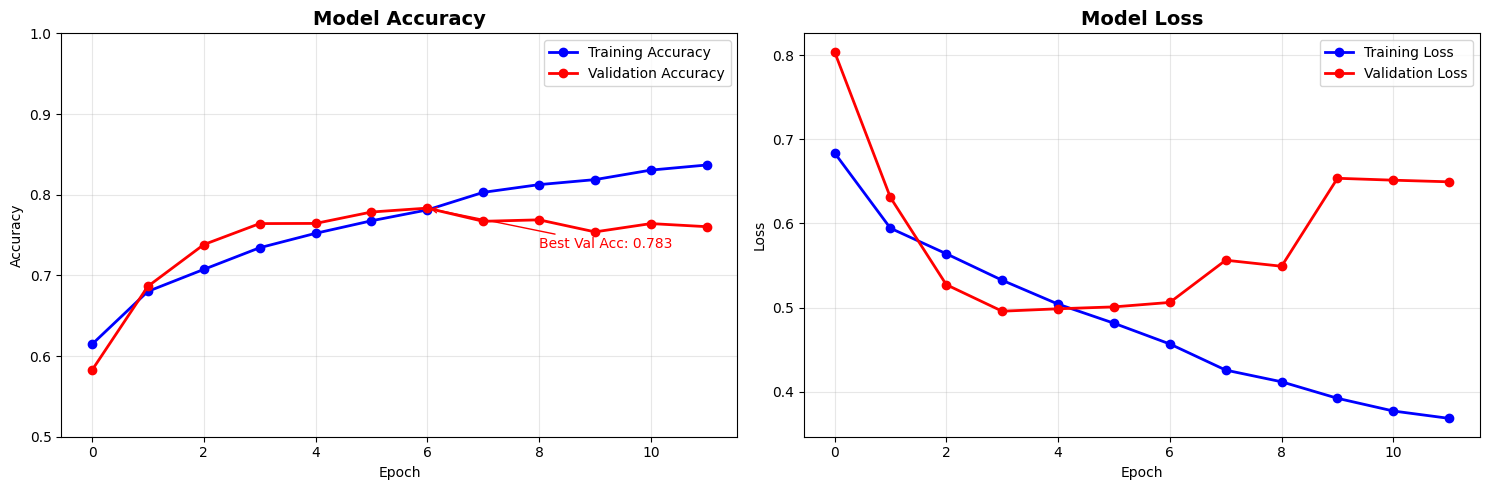


📊 TRAINING SUMMARY:
Final Training Accuracy: 0.837
Final Validation Accuracy: 0.760
Best Validation Accuracy: 0.783
Gap (Overfitting): 0.076
✅ Good! Low overfitting

🎯 Final Results:
Validation Accuracy: 0.7834
Validation Loss: 0.5061


In [64]:
# Enhanced plotting function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.5, 1.0)

    # Add annotations for max validation accuracy
    max_val_acc = max(history.history['val_accuracy'])
    max_val_epoch = history.history['val_accuracy'].index(max_val_acc)
    ax1.annotate(f'Best Val Acc: {max_val_acc:.3f}',
                xy=(max_val_epoch, max_val_acc),
                xytext=(max_val_epoch+2, max_val_acc-0.05),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

    # Loss plot
    ax2.plot(history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])

    print(f"\n📊 TRAINING SUMMARY:")
    print(f"Final Training Accuracy: {final_train_acc:.3f}")
    print(f"Final Validation Accuracy: {final_val_acc:.3f}")
    print(f"Best Validation Accuracy: {best_val_acc:.3f}")
    print(f"Gap (Overfitting): {final_train_acc - final_val_acc:.3f}")

    if final_train_acc - final_val_acc < 0.1:
        print("✅ Good! Low overfitting")
    elif final_train_acc - final_val_acc < 0.2:
        print("⚠️ Moderate overfitting")
    else:
        print("🚨 High overfitting - need more regularization")

plot_training_history(history)

# Final evaluation
test_loss, test_accuracy = model.evaluate(val_ds, verbose=0)
print(f"\n🎯 Final Results:")
print(f"Validation Accuracy: {test_accuracy:.4f}")
print(f"Validation Loss: {test_loss:.4f}")


🎯 Final Results:
Validation Accuracy: 0.7834
Validation Loss: 0.5061


In [1]:
import tensorflow as tf
print(tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'